In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from data_splitting import X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load HateBERT model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
num_labels = 2  # hate or none-hate

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
E:\Python3.12\Lib\site-packages\transformers\modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

In [100]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

X_train.columns = ['file name', 'message']
X_val.columns = ['file name', 'message']
X_test.columns = ['file name', 'message']

X_train

,file name,message
0,hate_video_130.wav,User1: I think you hate white people User2: I ...
1,session_036.wav,"User1: Hey, have you tried VR painting classes..."
2,session_028.wav,"User1: Hey, have you tried virtual book clubs ..."
3,hate_video_2.wav,"User1: One day, a nigger caught something in h..."
4,session_029.wav,"User1: Hey, have you tried sharing VR travel e..."
...,...,...
75,hate_video_81.wav,User1: He's not fucking destroyed by me! Damn!...
76,session_004.wav,"User1: Hey, have you tried team-building exerc..."
77,session_010.wav,"User1: Hey, have you tried VR storytelling ses..."
78,hate_video_118.wav,"User1: You're a black nigger User2: No, you kn..."


In [101]:
from datasets import Dataset

# 构造 DataFrame
train_df = pd.DataFrame({"text": X_train["message"], "labels": y_train})
val_df = pd.DataFrame({"text": X_val["message"], "labels": y_val})
test_df = pd.DataFrame({"text": X_test["message"], "labels": y_test})

# 转换为 Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenization text data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# 批量处理数据
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# train_data_vec = X_train['message'].apply(preprocess_data)
# val_data_vec = X_val['message'].map(preprocess_data)
# test_data_vec = X_test['message'].map(preprocess_data)

print(train_dataset)

Map: 100%|██████████| 10/10 [00:00<00:00, 1666.92 examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 80
})


In [102]:
# 转换为 PyTorch dataset
def convert_to_torch(data):
    return {key: torch.tensor(val) for key, val in data.items() if key in ["input_ids", "attention_mask", "labels"]}

train_dataset = list(map(convert_to_torch, train_dataset))
val_dataset = list(map(convert_to_torch, val_dataset))
test_dataset = list(map(convert_to_torch, test_dataset))


# 创建 PyTorch DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2)

In [103]:
# 检查一下

for batch in train_dataloader:
    print(batch.keys())  # 确保 `labels` 存在
    print("Batch labels:", batch["labels"])  # 打印部分 labels
    print("Unique labels:", torch.unique(batch["labels"]))  # 查看标签的唯一值
    break

import numpy as np

train_labels = np.array([ex["labels"] for ex in train_dataset])
val_labels = np.array([ex["labels"] for ex in val_dataset])

print("Train label distribution:", np.bincount(train_labels))
print("Val label distribution:", np.bincount(val_labels))

dict_keys(['labels', 'input_ids', 'attention_mask'])
Batch labels: tensor([1, 1])
Unique labels: tensor([1])
Train label distribution: [40 40]
Val label distribution: [5 5]


In [109]:
# 设置训练轮数
epoch_num = 3

# 设置优化器 (AdamW) 和学习率调度器
# AdamW 是 transformers 推荐的优化器,线性学习率调度器可防止模型训练过快导致不稳定
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=0.01)
num_training_steps = len(train_dataloader) * epoch_num  # 训练 3 轮
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [112]:
print(len(train_dataset))
print(len(val_dataset))

80
10


100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


Epoch 1/3 - Train Acc: 0.5000 - Val Acc: 0.5000


100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


Epoch 2/3 - Train Acc: 0.5500 - Val Acc: 0.5000


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


Epoch 3/3 - Train Acc: 0.4250 - Val Acc: 0.5000


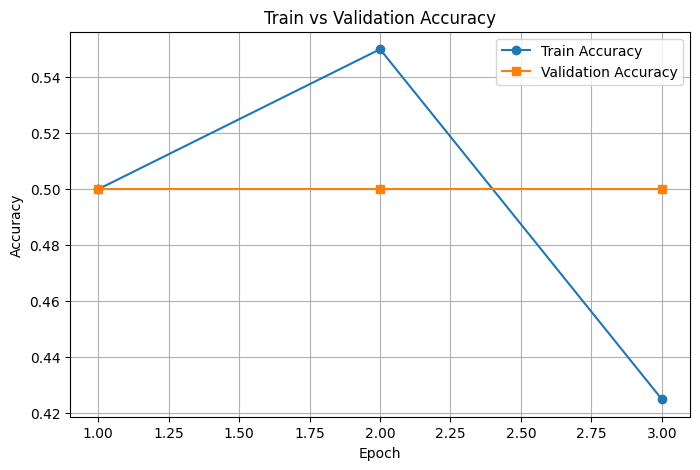

In [111]:
# 微调模型的 classifier 层
from tqdm import tqdm
from matplotlib import pyplot as plt

# 初始化存储训练和验证准确率的列表
train_accuracies = []
val_accuracies = []
epochs = epoch_num  # 训练轮数

# 训练 Loop
for epoch in range(epochs):

    model.train()

    correct_train = 0
    total_train = len(train_dataset)
    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        batch = {key: val.to(device) for key, val in batch.items()}

        # print(batch['labels'])

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # 计算训练集准确率
        preds = torch.argmax(outputs.logits, dim=-1)
        correct_train += (preds == batch["labels"]).sum().item()

        # total_train += batch["labels"].size(0)

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # 计算验证集准确率
    model.eval()
    correct_val = 0
    total_val = len(val_dataset)

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {key: val.to(device) for key, val in batch.items()}

            outputs = model(**batch)

            preds = torch.argmax(outputs.logits, dim=-1)
            correct_val += (preds == batch["labels"]).sum().item()

            # total_val += batch["labels"].size(0)

    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

# 绘制训练和验证准确率曲线
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# for epoch in range(epochs):
#     loop = tqdm(train_dataloader, leave=True)
#     for batch in loop:
#         batch = {key: val.to(device) for key, val in batch.items()}  # 移动到 GPU/CPU
#
#         optimizer.zero_grad()
#         outputs = model(**batch)  # 前向传播
#         loss = outputs.loss  # 计算损失
#         loss.backward()  # 反向传播
#         optimizer.step()  # 更新参数
#         lr_scheduler.step()  # 调整学习率
#
#         loop.set_description(f"Epoch {epoch+1}")
#         loop.set_postfix(loss=loss.item())